
# Week 3 - Clustering & Topic Modeling

This week, we take a text corpus that we have developed, and we first break it into discrete document chunks through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of content clustering called topic modeling. This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. Finally, we will consider how to construct models that take document cluster and topic loading as predictive features.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

F:\Python\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [ ]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

We can ascertain the categories with `target_names` or the actual files with `filenames`

In [ ]:
print(newsgroups.target_names)
print(len(newsgroups.data))

We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [ ]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [ ]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [ ]:
newsgroupsVects

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [ ]:
newsgroupsVects[:10,:20].toarray()

We can also lookup the indices of different words using the Vectorizer

In [ ]:
ngCountVectorizer.vocabulary_.get('vector')

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [ ]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

This gives us the tf-idf for each word in each text

In [ ]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [ ]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [ ]:
newsgroupsDF['text']

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [ ]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [ ]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

Then we can initialize our cluster finder

In [ ]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [ ]:
km.fit(newsgroupsTFVects)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [ ]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [ ]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

We can also look at the distinguishing features in each cluster:

In [ ]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [ ]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [ ]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [ ]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

Let's plot the data using the true labels as the colors of our data points.

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

In [ ]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [ ]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [ ]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [ ]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters

In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [ ]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [ ]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [ ]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [ ]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [ ]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [ ]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

And visualize:

In [ ]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

In [ ]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters; with Silhouette analysis or maybe some of the metric although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [ ]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

**In the first part I want to explore if writing style sometimes might have a negative influence on clustering.**  

I choose Plato's and Aristotle's corpus and some famous books from Nietzsche and Kant as my content. It is worth noting that Plato's books are completely different from since it is dialogue and Nietzsche's books are also different different because it's writing style is silimar to aphorism and prose. However, since I don't have Nietzsche's and Kant's all books, the emphasis will be on Plato and Aristotle.

At first, I will cluster their books without removing some confounding features.

In [2]:
import os
import re
import random
random.seed(100)

targetDir = '../corpora1'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path) as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

plato_df = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'author'})

Aristotle = plato_df[0:28].replace('author', 'Aristotle' )

Kant = plato_df[28:34].replace('author', 'Kant' )

Nietzsche = plato_df[34:40].replace('author', 'Nietzsche' )

Plato = plato_df[40:].replace('author', 'Plato' )

corpora_df = pandas.concat([Aristotle, Kant, Nietzsche, Plato])
corpora_no_remove = pandas.concat([Aristotle, Kant, Nietzsche, Plato])

# Remove some features vectors 
remove = np.array(['replied', 'Crito', 'Cleinias', 'Timaeus', 'Protagoras', 'Theaetetus',
                   'Phaedrus', 'Phaedo', 'SOCRATES', 'Socrates', 'Philebus', 'Parmenides',
                   'Euthyphro', 'Meno', 'Nicias', 'Polus', 'Cratylus', 'Theodorus', 'Menexenus', 
                   'Nicias', 'Ion', 'Dion', 'Simmias', 'Agathon', 'Hellenes', 'Gorgias', '\n', 't'
                   'theodorus', 'DIALOGUE', 'Athens', 'Athenian', 'Author', 'Athenians', 'THEODORUS'])
       
for i in range(corpora_df.shape[0]):
    for j in range(len(remove)):
        corpora_df["text"].iloc[i] = re.sub(remove[j], ' ', corpora_df["text"].iloc[i])


for i in range(corpora_df.shape[0]):
    corpora_no_remove["text"].iloc[i] = re.sub('\n', ' ', corpora_no_remove["text"].iloc[i])
for i in range(corpora_df.shape[0]):
    corpora_no_remove["text"].iloc[i] = re.sub('\t', ' ', corpora_no_remove["text"].iloc[i])



corpora_no_remove[1::5]

,author,book,text
1,Aristotle,Aristotle_Category.txt,The Categories By Aristotle Section 1 Pa...
6,Aristotle,Aristotle_Generation_Corruption.txt,BOOK I Part 1 Our next task is to study com...
11,Aristotle,Aristotle_Memory_Reminiscence.txt,On Memory and Reminiscence By Aristotle Tra...
16,Aristotle,Aristotle_Physics.txt,BOOK I Part 1 When the objects of an inqu...
21,Aristotle,Aristotle_Prophesying_Dreams.txt,Part 1 As to the divination which takes pla...
26,Aristotle,Aristotle_Soul.txt,"BOOK I Part 1 Holding as we do that, whil..."
31,Kant,Kant_Practical_Reason.txt,THE CRITIQUE OF PRACTICAL REASON b...
36,Nietzsche,Nietzsche_Byond_Good_and_Eval.txt,BEYOND GOOD AND EVIL By Friedrich Nietzsche ...
41,Plato,Plato_Charmides.txt,"Charmidest SCENE: The Palaestra of Taureas, wh..."
46,Plato,Plato_Euthyphro.txt,"Euthyphro PERSONS OF THE DIALOGUE: Socrates, E..."


In [3]:
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
no_removeVects = ngCountVectorizer.fit_transform(corpora_no_remove['text'])
print("Not Remove:", no_removeVects.shape)

Not Remove: (66, 35019)


In [4]:
ngCountVectorizer.vocabulary_.get('vector')
no_removeTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(no_removeVects)
no_removeTF= no_removeTFTransformer.transform(no_removeVects)
print("Not Remove:", no_removeTF.shape)
print("Not Remove:"'\n', list(zip(ngCountVectorizer.vocabulary_.keys(), no_removeTF.data))[:10])

Not Remove: (66, 35019)
Not Remove:
 [('section', 0.003908121077267606), ('part', 0.03454357552492746), ('we', 0.0397037775743434), ('must', 0.045375745799249606), ('now', 0.00708996028113275), ('treat', 0.0021143970985858245), ('of', 0.2899793754983295), ('youth', 0.003021392923869591), ('and', 0.24814860983964626), ('old', 0.007412391939110719)]


F:\Python\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [5]:
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
no_removeTFVects = ngTFVectorizer.fit_transform(corpora_no_remove['text'])
no_removeTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(no_removeVects)
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['section', 'respiration', 'control', 'members', 'divisions', 'faculties', 'endowed', 'viz', 'alive', 'qua'] ...


F:\Python\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [6]:
numClusters = len(set(corpora_no_remove['author']))
km_no_remove = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km_no_remove.fit(no_removeTFVects)
print('\n'"Not Remove:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(corpora_no_remove['author'], km_no_remove.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(corpora_no_remove['author'], km_no_remove.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(corpora_no_remove['author'], km_no_remove.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(corpora_no_remove['author'], km_no_remove.labels_)))


Not Remove:
Homogeneity: 0.520
Completeness: 0.508
V-measure: 0.514
Adjusted Rand Score: 0.476


In [7]:
corpora_no_remove['kmeans_predictions'] = km_no_remove.labels_
terms_no_remove = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km_no_remove.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms_no_remove[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 genus
 organ
 contraries
 premisses
 blood
 potentially
 sanguineous
 predicated
 flesh
 moist


Cluster 1:
 replied
 crito
 pleasures
 cleinias
 temperance
 phaedrus
 government
 country
 author
 ion


Cluster 2:
 theaetetus
 stranger
 theodorus
 king
 government
 sophist
 divide
 political
 letters
 protagoras


Cluster 3:
 priori
 moral
 dreams
 morality
 practical
 concept
 german
 empirical
 dream
 christian




In [8]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(no_removeTFVects.toarray())
reduced_data = pca.transform(no_removeTFVects.toarray())
components = pca.components_
keyword_no_remove_ids = list(set(order_centroids[:,:10].flatten()))
words = [terms_no_remove[i] for i in keyword_no_remove_ids]
x = components[:,keyword_no_remove_ids][0,:]
y = components[:,keyword_no_remove_ids][1,:]
colordict = {
'Aristotle': 'red',
'Kant': 'orange',
'Nietzsche': 'green',
'Plato': 'blue',
    }
colors = [colordict[c] for c in corpora_no_remove['author']]
print("The author' colors are:\n{}".format(colordict.items()))

The author' colors are:
dict_items([('Aristotle', 'red'), ('Kant', 'orange'), ('Nietzsche', 'green'), ('Plato', 'blue')])


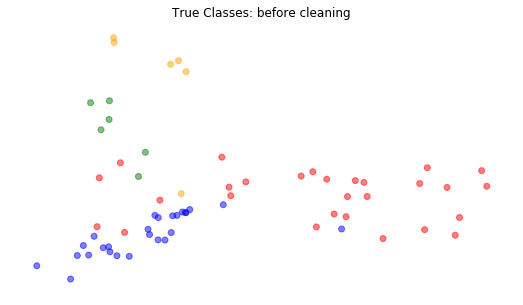

In [9]:
fig = plt.figure(figsize = (9,5))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes: before cleaning')
plt.show()

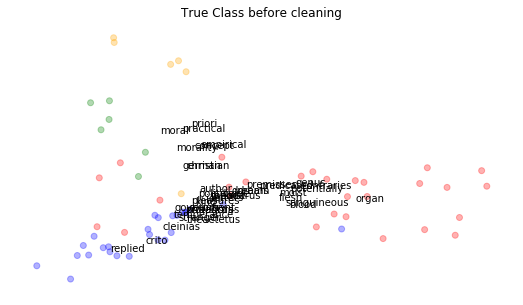

In [10]:
fig = plt.figure(figsize = (9,5))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Class before cleaning')
plt.show()

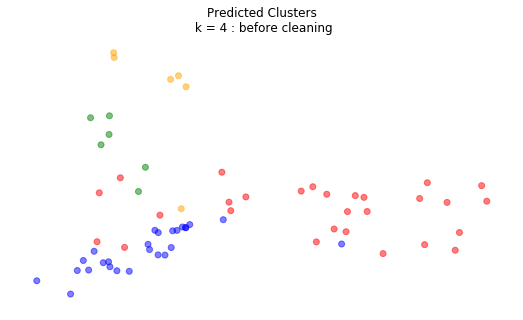

In [11]:
fig = plt.figure(figsize = (9,5))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4 : before cleaning')
plt.show()

In [12]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

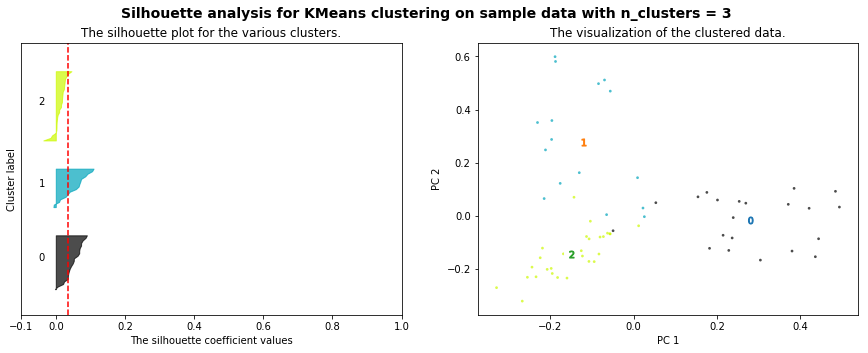

For n_clusters = 3, The average silhouette_score is : 0.034


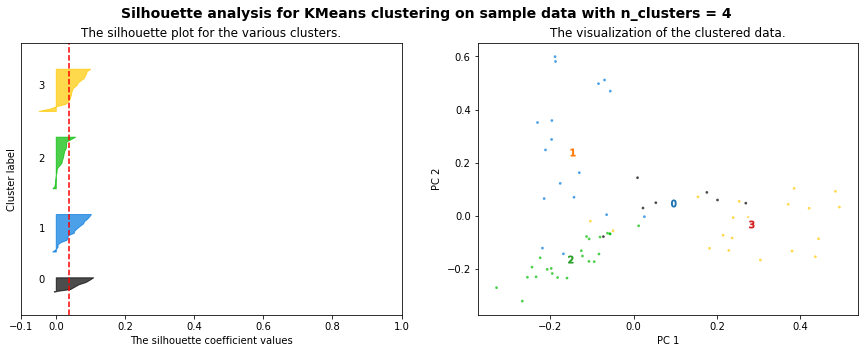

For n_clusters = 4, The average silhouette_score is : 0.038


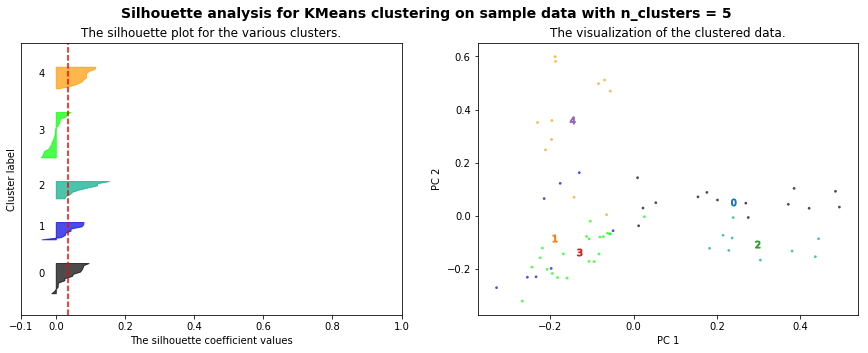

For n_clusters = 5, The average silhouette_score is : 0.035


In [13]:
X = no_removeTFVects.toarray()
plotSilhouette(3, X)

X = no_removeTFVects.toarray()
plotSilhouette(4, X)

X = no_removeTFVects.toarray()
plotSilhouette(5, X)

### Cluster before cleaning:

This is the cluster results before we cleaning the texts. We can find some feature we may don't want them to appear if our research objective is to analyze philosophic topics: in Plato's cluster, we find trivial conversation word such as "replied" and many Greek names such as "crito", "theaetetus", "cleinias" and so on. These kind of words without substantial meaning might have a negative effect on the result. In order to tell if there is any influence, I clean around 30 Greek names and the word "replied".

In [14]:
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
corporaVects = ngCountVectorizer.fit_transform(corpora_df['text'])
print("Name Remove:", corporaVects.shape)

ngCountVectorizer.vocabulary_.get('vector')
corporaTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(corporaVects)
corporaTF = corporaTFTransformer.transform(corporaVects)
print('Name Remove:''\n', list(zip(ngCountVectorizer.vocabulary_.keys(), corporaTF.data))[:10])

ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
corporaTFVects = ngTFVectorizer.fit_transform(corpora_df['text'])
corporaTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(corporaVects)

try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))
  
numClusters = len(set(corpora_df['author']))
km_remove = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km_remove.fit(corporaTFVects)
print('Not Remove:''\n', km_remove.fit(corporaTFVects))


print('\n'"Name Remove:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(corpora_df['author'], km_remove.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(corpora_df['author'], km_remove.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(corpora_df['author'], km_remove.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(corpora_df['author'], km_remove.labels_)))



corpora_df['kmeans_predictions'] = km_remove.labels_

terms_remove = ngTFVectorizer.get_feature_names()
print("")
print("Top terms per cluster:")
order_centroids = km_remove.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms_remove[ind])
    print('\n')

Name Remove: (66, 35004)
Name Remove:
 [('section', 0.003908129140705784), ('part', 0.03454364679702477), ('we', 0.03970385949323731), ('must', 0.04537583942084264), ('now', 0.0070899749095066624), ('treat', 0.0021144014611196226), ('of', 0.2899799737988225), ('youth', 0.0030213991577642354), ('and', 0.2481491218327332), ('old', 0.007412407232742357)]


F:\Python\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


vector is missing
The available words are: ['section', 'respiration', 'control', 'members', 'divisions', 'faculties', 'endowed', 'viz', 'alive', 'qua'] ...
Not Remove:
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Name Remove:
Homogeneity: 0.468
Completeness: 0.425
V-measure: 0.446
Adjusted Rand Score: 0.406

Top terms per cluster:
Cluster 0:
 genus
 contraries
 premisses
 predicated
 propositions
 syllogism
 premiss
 proposition
 substances
 negative


Cluster 1:
 moral
 priori
 practical
 morality
 concept
 dreams
 empirical
 german
 christian
 christianity


Cluster 2:
 stranger
 temperance
 lover
 country
 government
 praise
 pleasures
 poets
 letters
 citizens


Cluster 3:
 organ
 blood
 sanguineous
 organs
 plants
 fishes
 insects
 moisture
 lung
 flesh




In [15]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(corporaTFVects.toarray())
reduced_data = pca.transform(corporaTFVects.toarray())
components = pca.components_
keyword_remove_ids = list(set(order_centroids[:,:10].flatten()))
words = [terms_remove[i] for i in keyword_remove_ids]
x = components[:,keyword_remove_ids][0,:]
y = components[:,keyword_remove_ids][1,:]
colordict = {
'Aristotle': 'red',
'Kant': 'orange',
'Nietzsche': 'green',
'Plato': 'blue',
    }
colors = [colordict[c] for c in corpora_df['author']]
print("The author' colors are:\n{}".format(colordict.items()))

The author' colors are:
dict_items([('Aristotle', 'red'), ('Kant', 'orange'), ('Nietzsche', 'green'), ('Plato', 'blue')])


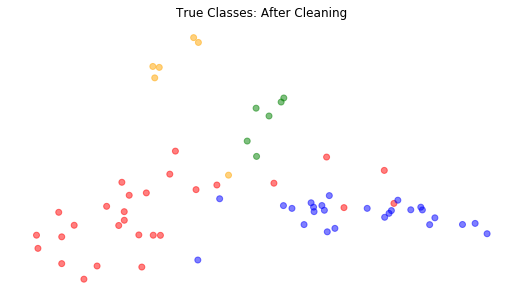

In [16]:
fig = plt.figure(figsize = (9,5))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes: After Cleaning')
plt.show()

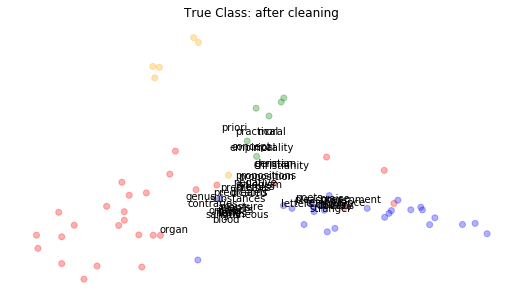

In [17]:
fig = plt.figure(figsize = (9,5))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Class: after cleaning')
plt.show()

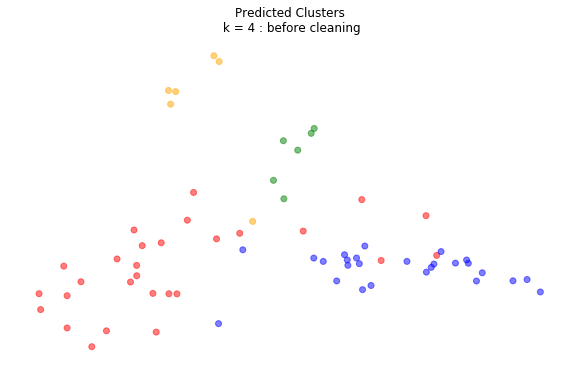

In [18]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4 : before cleaning')
plt.show()

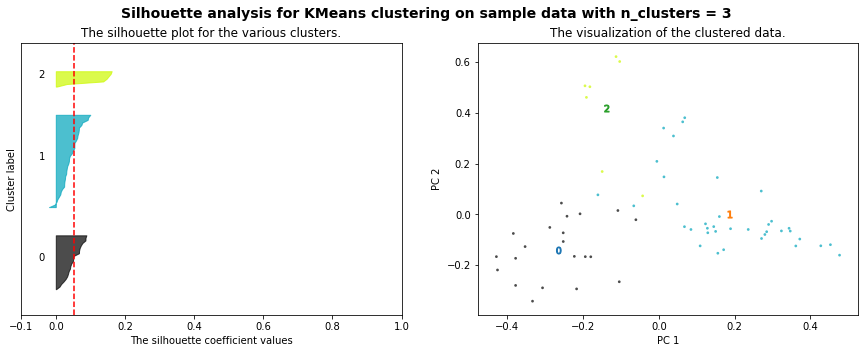

For n_clusters = 3, The average silhouette_score is : 0.051


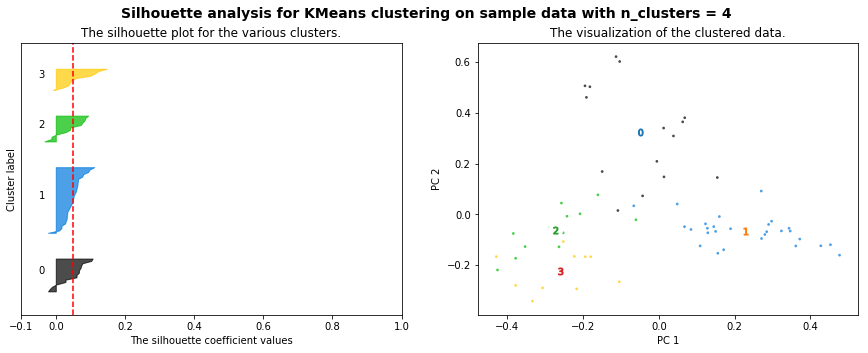

For n_clusters = 4, The average silhouette_score is : 0.049


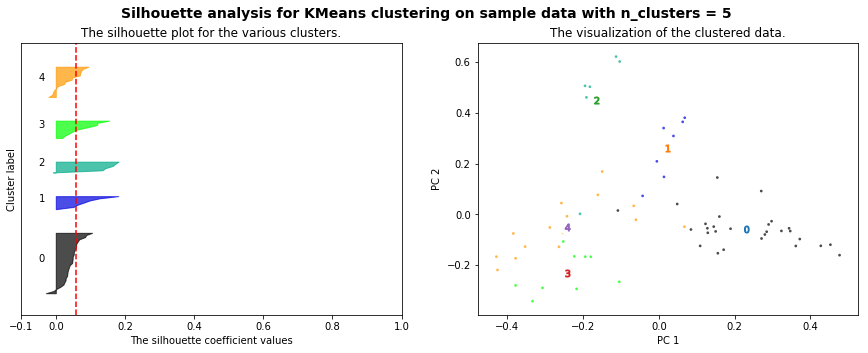

For n_clusters = 5, The average silhouette_score is : 0.058


In [19]:
X = corporaTFVects.toarray()
plotSilhouette(3, X)

X = corporaTFVects.toarray()
plotSilhouette(4, X)

X = corporaTFVects.toarray()
plotSilhouette(5, X)

In [20]:
print('\n'"Name Remove:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(corpora_df['author'], km_remove.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(corpora_df['author'], km_remove.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(corpora_df['author'], km_remove.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(corpora_df['author'], km_remove.labels_)))

print('\n'"Not Remove:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(corpora_no_remove['author'], km_no_remove.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(corpora_no_remove['author'], km_no_remove.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(corpora_no_remove['author'], km_no_remove.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(corpora_no_remove['author'], km_no_remove.labels_)))


Name Remove:
Homogeneity: 0.468
Completeness: 0.425
V-measure: 0.446
Adjusted Rand Score: 0.406

Not Remove:
Homogeneity: 0.520
Completeness: 0.508
V-measure: 0.514
Adjusted Rand Score: 0.476


### Compare results before and after cleaning

Now we can compare the results before and after cleaning through a set of indictors. First, the general distributions of two sets of results are similar, but they still have a few difference. Besides, Silhouette scores are very different. generally speaking, the scores after cleaning are much higher than those before cleaning. The best number of mean also changes. Before cleaning 3K mean is the best but after cleaning 3K mean becomes the worst. If we compare them by V-measure and adjusted rand score, we will find that the scores before cleaning are relatively higher than those after cleaning. Therefore, we may conclude that some features derived from writing style is not a good choice.

However, I think whether this conclusion is ture depends on our objectives. It is worth noting that this clusering is for identifying author. In this case, writing style is super important since Plato is so different so that his writing style features such as numerous Greek names and trivial conversation words can help the algorithm. However, if the objective is to identify philosophic topic rather than author, these kind of features might be confounding variables. Besides, I think we should also think about another situation: if we remove some philosophic topics and left writing style features, will the scores becomes higher? Therefore, we need to pay attention to the tension between writing style and substantial topics especially when we deal with a corpora consisting of many styles and substantial topics. Although in my texts they do not bring a lot of trouble, but the comparaision shows they have this kind of potential.

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [ ]:
newsgroupsTFVects[:100].todense()

In [ ]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [ ]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [ ]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [ ]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

Now we can visualize the tree

In [ ]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

In [ ]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [ ]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [ ]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [ ]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

# Now let's do it with our new data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [ ]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

And visualize the tree:

In [ ]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [ ]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

As we only used one senator for this there isn't any point in looking at the metrics, but you should if possible

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

In [21]:
corporaTFVects

corporaTFVects[:100].todense()

corporaCoocMat = corporaTFVects * corporaTFVects.T

corporaCoocMat.setdiag(0)

selectIndices = []
indexToCat = []
for c in set(corpora_df['author']):
    selectIndices += list(corpora_df[corpora_df['author'] == c].index)[:50]
    indexToCat += [c] * 50
    
subCoocMat = corporaCoocMat[selectIndices,:][:,selectIndices]

linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

F:\Python\lib\site-packages\scipy\cluster\hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 6.        , 54.        ,  0.31429528,  2.        ],
       [41.        , 53.        ,  0.35420873,  2.        ],
       [23.        , 33.        ,  0.3623502 ,  2.        ],
       [17.        , 22.        ,  0.39447267,  2.        ],
       [48.        , 67.        ,  0.42294159,  3.        ],
       [40.        , 52.        ,  0.43164479,  2.        ],
       [57.        , 70.        ,  0.44675921,  4.        ],
       [14.        , 43.        ,  0.45895795,  2.        ],
       [19.        , 26.        ,  0.46499254,  2.        ],
       [ 0.        ,  1.        ,  0.47493191,  2.        ]])

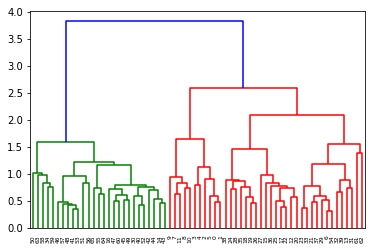

In [22]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

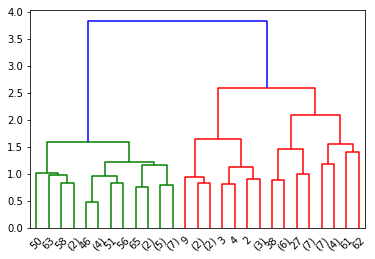

In [23]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

In [24]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 3, 4, 1, 3, 1, 3, 3, 3, 3, 4,
       3, 4, 3, 3, 3, 3, 3, 4, 1, 4, 4, 4, 1, 3, 3, 4, 3, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1],
      dtype=int32)

In [25]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(corporaCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(corpora_df['author'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(corpora_df['author'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(corpora_df['author'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(corpora_df['author'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.621
Completeness: 0.549
V-measure: 0.583
Adjusted Rand Score: 0.493


F:\Python\lib\site-packages\scipy\cluster\hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


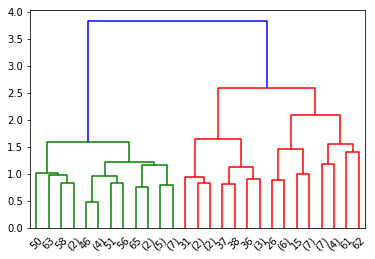

In [26]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix_full, p=4, truncate_mode='level', get_leaves=True)

In [27]:
corpora_df['wald_predictions'] = hierarchicalClusters_full
corpora_df[1::5]

,author,book,text,kmeans_predictions,wald_predictions
1,Aristotle,Aristotle_Category.txt,The Categories By Aristotle Section 1 Pa...,0,4
6,Aristotle,Aristotle_Generation_Corruption.txt,BOOK I Part 1 Our next task is to study com...,0,3
11,Aristotle,Aristotle_Memory_Reminiscence.txt,On Memory and Reminiscence By Aristotle Tra...,1,4
16,Aristotle,Aristotle_Physics.txt,BOOK I Part 1 When the objects of an inqu...,0,3
21,Aristotle,Aristotle_Prophesying_Dreams.txt,Part 1 As to the divination which takes pla...,1,4
26,Aristotle,Aristotle_Soul.txt,"BOOK I Part 1 Holding as we do that, whil...",3,3
31,Kant,Kant_Practical_Reason.txt,\t\t THE CRITIQUE OF PRACTICAL REASON \t\t\...,1,2
36,Nietzsche,Nietzsche_Byond_Good_and_Eval.txt,BEYOND GOOD AND EVIL By Friedrich Nietzsche ...,1,2
41,Plato,Plato_Charmides.txt,"Charmidest SCENE: The Palaestra of Taureas, wh...",2,1
46,Plato,Plato_Euthyphro.txt,"PERSONS OF THE : , . SCENE: The Porch of...",2,1


When we don't set the number of clusters, the hierarchical clustering automatically divide them into two main clusters. It might not a good choice. However, we can also find that this two main groups can also be divided into four subgroups. Furthermore, if we set the number of cluster, its v-measure score and adjusted rand socre are better than K-mean. Therefore, at least in my texts, hierarchical clustering is a better method because it has a better predictive power with more explanatory power. But the Silhouette score shows for K-mean method, 5K is much better than 4K (we use 4K). So we still don't know whether the 4K-mean method will be better.

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [ ]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: nltk.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))
senReleasesTraining[::100]

In [ ]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [ ]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [ ]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [ ]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [ ]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [ ]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [ ]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [ ]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [ ]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

First we can visualize as a stacked bar chart:

In [ ]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

In [ ]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [ ]:
senlda.show_topic(1)

And if we want to make a dataFrame:

In [ ]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

In [ ]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [ ]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

In [ ]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

I select 2 aristotle's, 3 plato's, 2 Nietzsche's and 2 Kant's books.

In [225]:
targetDir = '../aris'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path) as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

aris = pandas.DataFrame({'text' : platoText, 'book' : platoFileName})

remove_aris = np.array(['one', '\n', 'onli', 'ani', 'would', 'say', 'said'])

for i in range(aris.shape[0]):
    for j in range(len(remove_aris)):
        aris["text"].iloc[i] = re.sub(remove_aris[j], ' ', aris["text"].iloc[i])
    
aris

,book,text
0,Aristotle_Constitution.txt,THE ATHENIAN CONSTITUTION by Aristotle P...
1,Aristotle_Ehics.txt,THE ETHICS OF ARISTOTLE ARISTOTLE'S ETHICS ...
2,Aristotle_Politics.txt,Title: Politics A Treatise on Governmen...
3,Kant_Metaphysics-Morals.txt,1785 ...
4,Kant_Practical_Reason.txt,\t\t THE CRITIQUE OF PRACTICAL REASON \t\t\...
5,Nietzsche_Byond_Good_and_Eval.txt,BEYOND GOOD AND EVIL By Friedrich Nietzsche ...
6,Nietzsche_Human_All_Too_Human.txt,"HUMAN, ALL TOO HUMAN A BOOK FOR FREE..."
7,Plato_Laws.txt,Laws BOOK I PERSONS OF THE DIALOGUE: An ATHENI...
8,Plato_Republic.txt,"Book I Of Wealth, Justice, Moderation, and The..."
9,Plato_Statesman.txt,"Statesman PERSONS OF THE DIALOGUE: Theodorus, ..."


In [238]:
from nltk.corpus import stopwords
stop_words_nltk = stopwords.words('english')

aris = aris.dropna(axis=0, how='any')

aris['tokenized_text'] = aris['text'].apply(lambda x: nltk.word_tokenize(x))
aris['normalized_tokens'] = aris['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = stop_words_nltk, stemmer = lucem_illud.stemmer_basic))


arisTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
arisTFVects = arisTFVectorizer.fit_transform(aris['text'])

F:\Python\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [239]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

aris['reduced_tokens'] = aris['normalized_tokens']

In [240]:
dictionary = gensim.corpora.Dictionary(aris['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in aris['reduced_tokens']]

gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

In [241]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [242]:
sen1Bow = dictionary.doc2bow(aris['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(aris['book'][0]))
print("are: {}".format(sen1lda))

The topics of the text: Aristotle_Constitution.txt
are: [(0, 0.011276467), (1, 0.032016974), (3, 0.07167861), (4, 0.80751014), (9, 0.07162195)]


In [243]:
ldaDF = pandas.DataFrame({
        'book' : aris['book'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in aris['reduced_tokens']]
    })

In [244]:
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF

,book,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,Aristotle_Constitution.txt,"[(1, 0.01921686), (3, 0.06551054), (4, 0.84990...",0.000000,0.019217,0.000000,0.065511,0.849906,0.000000,0.000000,0.000000,0.000000,0.053679
1,Aristotle_Ehics.txt,"[(1, 0.031286545), (2, 0.051741417), (3, 0.721...",0.000000,0.031287,0.051741,0.721618,0.067185,0.000000,0.032875,0.059958,0.029968,0.000000
2,Aristotle_Politics.txt,"[(1, 0.25531453), (2, 0.048050847), (3, 0.4466...",0.000000,0.255315,0.048051,0.446635,0.235057,0.000000,0.000000,0.000000,0.011965,0.000000
3,Kant_Metaphysics-Morals.txt,"[(0, 0.98750013)]",0.987500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Kant_Practical_Reason.txt,"[(0, 0.99656504)]",0.996565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Nietzsche_Byond_Good_and_Eval.txt,"[(0, 0.47811222), (4, 0.0136057725), (8, 0.497...",0.478112,0.000000,0.000000,0.000000,0.013606,0.000000,0.000000,0.000000,0.497189,0.000000
6,Nietzsche_Human_All_Too_Human.txt,"[(0, 0.1479572), (3, 0.013989367), (4, 0.07738...",0.147957,0.000000,0.000000,0.013989,0.077386,0.023592,0.000000,0.058669,0.675001,0.000000
7,Plato_Laws.txt,"[(2, 0.26642358), (3, 0.017246686), (4, 0.6046...",0.000000,0.000000,0.266424,0.017247,0.604670,0.000000,0.000000,0.000000,0.106864,0.000000
8,Plato_Republic.txt,"[(2, 0.3408192), (3, 0.11776188), (4, 0.259665...",0.000000,0.000000,0.340819,0.117762,0.259666,0.000000,0.000000,0.000000,0.275829,0.000000
9,Plato_Statesman.txt,"[(0, 0.9621262), (2, 0.0277213)]",0.962126,0.000000,0.027721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [245]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['book']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.019217,0.000000,0.065511,0.849906,0.000000,0.000000,0.000000,0.000000,0.053679
1,0.000000,0.031287,0.051741,0.721618,0.067185,0.000000,0.032875,0.059958,0.029968,0.000000
2,0.000000,0.255315,0.048051,0.446635,0.235057,0.000000,0.000000,0.000000,0.011965,0.000000
3,0.987500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.996565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.478112,0.000000,0.000000,0.000000,0.013606,0.000000,0.000000,0.000000,0.497189,0.000000
6,0.147957,0.000000,0.000000,0.013989,0.077386,0.023592,0.000000,0.058669,0.675001,0.000000
7,0.000000,0.000000,0.266424,0.017247,0.604670,0.000000,0.000000,0.000000,0.106864,0.000000
8,0.000000,0.000000,0.340819,0.117762,0.259666,0.000000,0.000000,0.000000,0.275829,0.000000
9,0.962126,0.000000,0.027721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


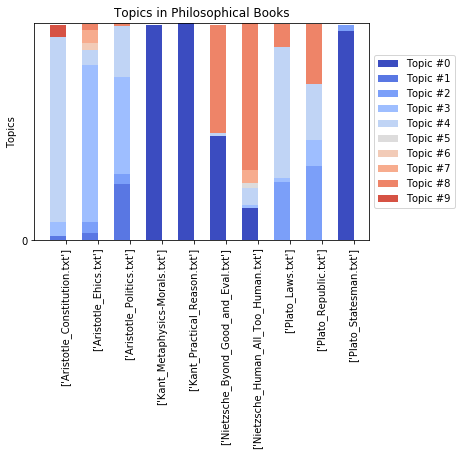

In [246]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Philosophical Books')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

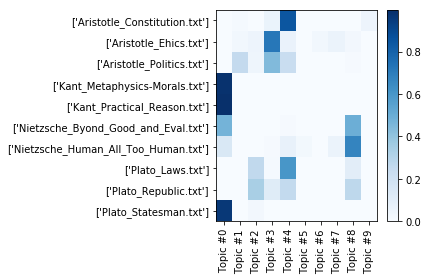

In [247]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [236]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,man,good,law,law,ani,may,shall,onli,man,ani
1,may,man,man,good,man,law,man,man,law,man
2,ani,may,may,man,good,ani,good,may,may,good
3,reason,reason,ani,onli,thing,good,law,state,good,may
4,thing,law,men,ani,shall,also,ani,also,ani,law
5,onli,ani,state,state,may,onli,onli,law,state,natur
6,state,moral,good,natur,law,thing,thing,ani,must,must
7,law,also,must,may,reason,state,state,good,men,onli
8,must,thing,onli,also,moral,must,reason,thing,also,athenian
9,good,onli,natur,must,like,govern,may,must,thing,men


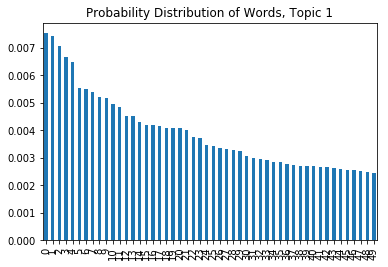

In [237]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

### When eta and alpha = auto     

From the graphs we can know that in most cases, the same author's different books have some overlapped topics. However, it is very abnormal that Plato’s Statesman almost only has one topic and is not associate with his other books. In common sense it should have shared some topics with his other works as his The Republic and Laws do. Besides, The Republic and Laws contain many topics.

In [271]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha=0.99999, eta = 0.02)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha=0.00001, eta = 0.02)

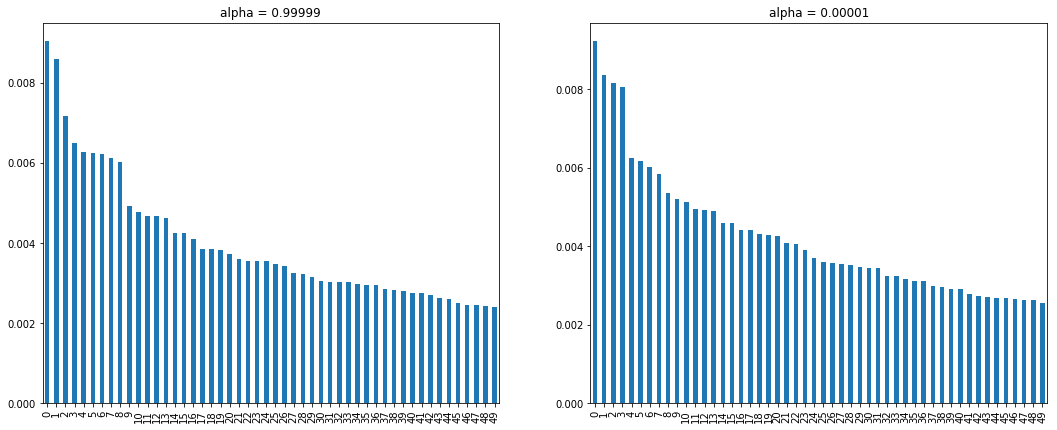

In [276]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = 'alpha = 0.99999')
topic21_df.plot.bar(legend = False, ax = ax2, title = 'alpha = 0.00001')
plt.show()

In [266]:
topicsDict = {}
for topicNum in range(senlda1.num_topics):
    topicWords = [w for w, p in senlda1.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,law,state,man,good,law,ani,man,may,good,may
1,ani,man,ani,ani,reason,may,good,thing,law,ani
2,man,thing,good,man,man,man,onli,ani,may,man
3,shall,men,may,may,may,law,natur,good,onli,natur
4,onli,may,thing,state,ani,must,also,onli,men,law
5,natur,law,law,onli,good,good,must,state,state,onli
6,let,onli,must,thing,onli,men,ani,man,man,good
7,may,also,onli,reason,also,natur,law,natur,also,also
8,also,good,men,must,state,state,thing,law,ani,reason
9,must,differ,us,also,must,onli,state,must,thing,thing


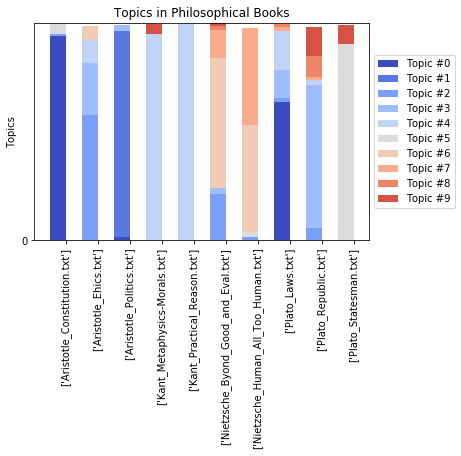

In [267]:
sen1Bow = dictionary.doc2bow(aris['reduced_tokens'][0])
sen1lda = senlda1[sen1Bow]

ldaDF = pandas.DataFrame({
        'book' : aris['book'],
        'topics' : [senlda1[dictionary.doc2bow(l)] for l in aris['reduced_tokens']]
    })



topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda1.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda1.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['book']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV
                                                        
N = 10
ind = np.arange(N)
K = senlda1.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Philosophical Books')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

In [268]:
topicsDict = {}
for topicNum in range(senlda2.num_topics):
    topicWords = [w for w, p in senlda2.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,man,may,ani,law,law,man,man,law,ani,man
1,ani,state,law,may,may,may,thing,ani,man,good
2,thing,man,man,good,ani,reason,reason,may,good,onli
3,law,law,may,state,man,onli,onli,good,must,men
4,good,also,must,onli,state,also,may,man,may,must
5,onli,ani,onli,ani,onli,thing,also,onli,thing,may
6,must,onli,thing,shall,good,good,ani,reason,state,thing
7,state,good,good,reason,also,ani,law,shall,reason,shall
8,also,reason,natur,also,reason,law,men,natur,natur,natur
9,may,men,state,man,shall,men,state,thing,like,becaus


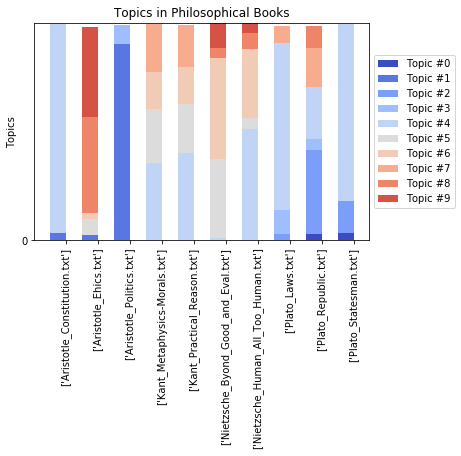

In [269]:
sen1Bow = dictionary.doc2bow(aris['reduced_tokens'][0])
sen1lda = senlda2[sen1Bow]

ldaDF = pandas.DataFrame({
        'book' : aris['book'],
        'topics' : [senlda2[dictionary.doc2bow(l)] for l in aris['reduced_tokens']]
    })



topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda2.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda2.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['book']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV
                                                        
N = 10
ind = np.arange(N)
K = senlda2.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Philosophical Books')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

I fix eta and change the alpha. When the alpha increases, differnt texts would become more close to each other in terms of topic. When the alpha decreases, they would become more different. In other words, whe the alpha increases, more words in each topic are given enough weight. Therefore, change the parameters in LDA would have a very huge influence on the results.